#### Date: 3-18-2022
#### Updates:
- First version in Git
- More automated/standardized image import
- 
_________________

## Goals:
- In this notebook, we aim to take a set of aster images and extract ATP and and motor profiles.

----

#### Package Imports:

In [1]:
#Numpy
import numpy as np

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib inline
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

#For file reading
import glob as glob
import re
import os

#Scipy packages
import scipy.optimize

#For image plotting
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.transform

#For interactive features
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets

import pandas as pd

from tqdm.notebook import tqdm as tqdm

import panel as pn
pn.extension()

### A conglomeration of functions

In [2]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list=list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))
    
    return np.array(im_list)

<font color = 'purple'>
interp_fn takes an image and places a mask over the center aster region. from the the outside values the function interpolates what the interior of the image should look like. This corrects for an image where the first frame is photobleached - Neutral to channels   
</font>

In [3]:
def interp_fn(im, mask, max_power):
    """
    Perform a 2D polynomial interpolation of the image.
    
    Parameters
    ----------
    im : numpy array
        Image to be interpolated
        
    mask : numpy array
        A matrix with binary values of the same size as im.
        The value at a location is 1 if that pixel is considered
        as an input in the interpolation procedure.
        
    max_power : integer
        Highest power for any of the coordinates in the 
        interpolation function f(x,y) = \sum_{ij} a_{ij} x^i y^j
        
    Returns
    -------
    im_interp : numpy array
        Interpolated image
    """
    
    H, W = im.shape
    X, Y = np.meshgrid(np.arange(W)-0.5*W, np.arange(H)-0.5*H)
    i_set = []
    j_set = []
    
    n_ind = max_power + 1
    
    for i in range(n_ind):
        for j in range(n_ind):
            i_set.append(i)
            j_set.append(j)
            
    b_vec = np.zeros(n_ind**2)
    for n in range(n_ind**2):
        i = i_set[n]
        j = j_set[n]
        b_vec[n] = np.sum(X**i * Y**j * im * mask)
        
    A_mat = np.zeros([n_ind**2,n_ind**2])
    for n in range(n_ind**2):
        for m in range(n_ind**2):
            i = i_set[n]
            j = j_set[n]
            
            i_tilde = i_set[m]
            j_tilde = j_set[m]
            
            A_mat[n,m] = np.sum(X**(i+i_tilde) * Y**(j+j_tilde) * mask)
    
    a_vec = np.linalg.solve(A_mat, b_vec)
    
    im_interp = np.zeros([H, W])
    for n in range(n_ind**2):
        i = i_set[n]
        j = j_set[n]
        im_interp += a_vec[n] * X**i * Y**j
    
    # Subtract the camera offset (NEW)
    im_interp -= offset_camera
        
    return im_interp

In [4]:
#Original vahe ftn which i use for the motors
def norm_mat_fn_mot(im_ref, offset_camera, r_blur=20):
    """
    Generate a normalization matrix from a reference image.
    
    It is assumed that the reference image is taken for a sample
    with a spatially uniform protein concentration. The normalization
    value is everywhere greater than 1, except at the position of 
    the highest illumination.
    
    Parameters
    ----------
    im_ref : numpy array
        Reference image (e.g., the first frame in the MT channel).
    
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    r_blur : float
        Radius of blurring to be performed on the reference image 
        in order to remove noise and short length scale nonuniformities [px].
        
    Returns
    -------
    norm_mat : numpy array
        Normalization matrix
    """
    
    # Convert image into a float type
    im_ref = im_ref.astype(float)
    
#     # Subtract the camera offset (REMOVED FROM HERE AND INPUTTED INTO THE INTERPOLATED FTN BECAUSE I DO THAT FIRST)
#     im = im_ref - offset_camera
    
    # Rescale the image down for faster denoising
    rescale = 4.0
    im_resized = skimage.transform.rescale(im_ref, 1/rescale)
    
    # Median filter to remove hot pixels
    im_median = skimage.filters.median(im_resized, skimage.morphology.selem.disk(3.0))
    
    # Gaussian blur the image
    im_blur = skimage.filters.gaussian(im_median, r_blur)
    
    # Find the location of the peak
    ind_max = np.where(im_blur == im_blur.max())
    i_center, j_center = ind_max[0][0], ind_max[1][0]
    print("The vertical coordinate for the fluor peak is at " +str(i_center*rescale))
    print("The horizontal coordinate for the fluor peak is at " +str(j_center*rescale))
    
    # Peak fluorescence in the normalization image
    fluo_peak = im_blur[i_center, j_center]
    print("The fluo peak intensity value is " + str(fluo_peak))
    
    # Normalization matrix
    norm_mat = fluo_peak/im_blur 
    
    # Scale up the normalization matrix to the original size
    norm_mat = skimage.transform.rescale(norm_mat, rescale)
    
    return norm_mat

In [5]:

#Vahe uses r_blur = 20 and skimage.morphology.selem.disk(3.0). I pick r_blur=3 and disk 
#size 10 by trial and error it looks like this leaves the least ring from blurring in iATP
#and the median filter of 10 does the best smooth

def norm_mat_fn_iATP(im_ref, offset_camera, r_blur=3):
    """
    Generate a normalization matrix from a reference image.
    
    It is assumed that the reference image is taken for a sample
    with a spatially uniform protein concentration. The normalization
    value is everywhere greater than 1, except at the position of 
    the highest illumination.
    
    Parameters
    ----------
    im_ref : numpy array
        Reference image (e.g., the first frame in the MT channel).
    
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    r_blur : float
        Radius of blurring to be performed on the reference image 
        in order to remove noise and short length scale nonuniformities [px].
        
    Returns
    -------
    norm_mat : numpy array
        Normalization matrix
    """
    
    # Convert image into a float type
    im_ref = im_ref.astype(float)
    
#     # Subtract the camera offset
#     im = im_ref - offset_camera
    
    # Rescale the image down for faster denoising
    rescale = 4.0
    im_resized = skimage.transform.rescale(im_ref, 1/rescale)
    
    # Median filter to remove hot pixels
    im_median = skimage.filters.median(im_resized, skimage.morphology.selem.disk(10.0))
    
    # Gaussian blur the image
    im_blur = skimage.filters.gaussian(im_median, r_blur)
    
    # Find the location of the peak
    ind_max = np.where(im_blur == im_blur.max())
    i_center, j_center = ind_max[0][0], ind_max[1][0]
    
    # Peak fluorescence in the normalization image
    fluo_peak = im_blur[i_center, j_center]
    
    # Normalization matrix
    norm_mat = fluo_peak/im_blur 
    
    # Scale up the normalization matrix to the original size
    norm_mat = skimage.transform.rescale(norm_mat, rescale)
    
    return norm_mat

In [6]:
def calibrate_motor(im, norm_mat, offset_camera, auto_fluo, protein_per_fluo):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    protein_per_fluo : float
        Calibration factor for converting fluorescence units
        into protein concentration units.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    im = im.astype(float)
    im = skimage.filters.median(im)
    im = im - offset_camera
    im = im * norm_mat
    im = im - auto_fluo
    im = im * protein_per_fluo
    return im

In [7]:
#Intensity to µM iATP calibration function

def calibrate_iATP(im, norm_mat, offset_camera, auto_fluo, C_half, I_range, I_0):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    I_range : float
        Coefficient in Languimuir Binding
        
    I_0 : float
        Additive "b-intercept" in Languimuir binding.
        
    C_half : float
        Concentration at half max intensity.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    im = im.astype(float)
    im = skimage.filters.median(im)
    im = im - offset_camera 
    im = im * norm_mat
    im = im - auto_fluo
    im = (C_half*(im - I_0)) / (I_range - im + I_0)
    
    neg_vals = np.where(im < 0)
    
    return im

test_mat = np.array([[4, 5, 2], [8, 5, -3], [6, 8, -10], [89, 3, 7]])
neg_vals = np.where(test_mat <= 0)
test_mat[neg_vals] = 0
test_mat

In [8]:
def profile_fn_nowedge(im, r_min=2.5, dr=1.5, r_max=None, avg_method='median', n_positions=100):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """
    
    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)
    
    # Dimensions of the image
    H,W = im.shape
    
    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5*W-0.5
    y_center = 0.5*H-0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)    
    
    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    
    avg_ls = np.zeros(n_positions)
    std_ls = np.zeros(n_positions)
    
    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if r_max == None:
        r_max = 0.5*np.min([H,W])-0.5
    r_unif_ls = np.linspace(r_min, r_max, n_positions)
    
    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r-0.5*dr) & (r_ls < r+0.5*dr)]

        if avg_method == 'median':
            avg_ls[i] = np.median(dat)
        elif avg_method == 'mean':
            avg_ls[i] = np.mean(dat)
        else:
            raise ValueError('Incorrect averaging method specified.')

        std_ls[i] = np.std(dat)
    
    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]
    
    profile_output = {"r_unif_ls" : r_unif_ls,
                      "avg_ls"    : avg_ls,
                      "std_ls"    : std_ls,
                      "r_ls"      : r_ls,
                      "im_ls"     : im_ls}
    
    return profile_output

In [9]:
def profile_fn(im, r_min=2.5, dr=1.5, r_max=None, avg_method='median', n_positions=100, n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """
    
    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)
    
    # Dimensions of the image
    H,W = im.shape
    
    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5*W-0.5
    y_center = 0.5*H-0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)    
    angle_mat = np.mod(np.arctan2(y_mat-y_center, x_mat-x_center), 2*np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    
    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if r_max == None:
        r_max = 0.5*np.min([H,W])-0.5
    r_unif_ls = np.linspace(r_min, r_max, n_positions)
    
    # List of bin angles 
    angle_bins = np.radians(np.linspace(0,360,n_wedge+1)) 
    angles = 0.5*(angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin 
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r-0.5*dr) & (r_ls < r+0.5*dr)]
        angle_disk = angle_ls[(r_ls > r-0.5*dr) & (r_ls < r+0.5*dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk>angle_bins[k]) & (angle_disk<=angle_bins[k+1])]
            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)
            
          
    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.median(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.mean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')
   
    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk 
    im_ls = im_ls[r_ls <= r_max] 
    r_ls = r_ls[r_ls <= r_max]
    
    profile_output = {"r_unif_ls" : r_unif_ls, 
                      "avg_ls" : avg_ls, 
                      "std_ls" : std_ls, 
                      "avg_bin_mat" : avg_bin_mat, 
                      "angles" : angles, 
                      "r_ls" : r_ls, 
                      "im_ls": im_ls}

    return profile_output

In [10]:
def binary_im_generator(im_for_binary, percentile = 80):
    """
    Creates an image of ones for values above a threshold and zeros for all others. 
    This is essentially a mask. The image is the same size as the inputted image.
    
    Parameters:
    im_for_binary: image you wish to create a mask from
    percentile: uses the np.percentile function which thresholds above 
                the given percentile. Automatically set to 80
                
    Returns:
    A binary image to be used as a mask
    """
    
    im_binary = im_for_binary > np.percentile(im_for_binary, percentile)
    
    #plot the figures
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,8))

    loc0 = ax0.imshow(im_for_binary)
    fig.colorbar(loc0, ax=ax0, shrink = 0.5)
    ax0.set_title("inputted image")

    loc1 = ax1.imshow(im_binary, cmap = plt.cm.Greys_r)
    fig.colorbar(loc1, ax=ax1, shrink = 0.5)
    ax1.set_title("binary image")
    
    return im_binary

In [11]:
def find_center(im, w_half, r_thresh, r_blur, motor, \
                least_squares = True, n_search_half = 5, n_positions = 40):
    """
    Identify the center coordinates of the aster.
    
    Parameters
    ----------
    im : numpy array
        Cropped fluorescence image of motors or microtubules where the aster center is
        close to the image center.
        
    w_half : float
        Half the size of the window of points that are considered for 
        center identification.
        
    r_thresh : float
        Radius of the small circle of points that are excluded from the center
        identification procedure. This is used to prevent biasing the center
        due to high-intensity spots in the core.
        
    r_blur : float
        Size of Gaussian blurring for initial guessing of the center.
    
    least_squares : Boolean
        Indicator variables that is true is the least squares optimization is
        used (faster), and is false if a window search is used (slower).
        
    n_search_half : int
        Half the size of the window around the initial guess where the center
        is looked for.
        
    n_positions : int
        Number of positions considered when extracting radial profiles.
        
        
    Returns
    -------
    i_center : int
        i-coordinate of identified center
    
    j_center : int
        j-coordinate of identified center
    """
    length = im.shape[0]
    
    # Initial guess of the aster center
    i_max, j_max = int(0.5*length), int(0.5*length)

    def find_sd(location):
        """
        Calculate the array of standard deviations for a profile
        centered at 'location'.
        """
        # Current coordinates of the aster center
        i_curr, j_curr = location
        
        # Nearest integer coordinates
        ii = [int(i_curr), int(i_curr)+1]
        jj = [int(j_curr), int(j_curr)+1]
        
        # Array to store the average cropped images,
        # obtained by areal weighting of 4 contributions
        im_crop = np.zeros([2*w_half+1,2*w_half+1])
        w_tot = 0
        for i in ii:
            for j in jj:
                weight = (1-np.abs(i_curr-i))*(1-np.abs(j_curr-j))
                w_tot += weight
                im_crop += weight*im[i-w_half:i+w_half+1, j-w_half:j+w_half+1]
        
        profile_output = profile_fn(im_crop, r_thresh, n_positions = n_positions)
        std_ls = profile_output["std_ls"]
        return std_ls
    
    if least_squares:
        cost = np.inf
        param_init = [i_max, j_max]

        output = scipy.optimize.least_squares(find_sd, param_init, method="lm")
        i_center, j_center = output.x

        i_center = int(round(i_center))
        j_center = int(round(j_center))
    else:
        search_range = np.arange(-n_search_half, n_search_half)
        di_m, dj_m = np.meshgrid(search_range, search_range)
        std_sq_min = np.inf
        di_opt = 0
        dj_opt = 0

        for i in range(len(search_range)):
            for j in range(len(search_range)):
                i_curr = i_max + di_m[i,j]
                j_curr = j_max + dj_m[i,j]

                im_crop = im[i_curr-w_half:i_curr+w_half+1, j_curr-w_half:j_curr+w_half+1]
                profile_output = profile_fn(im_crop, r_thresh)
                std_ls = profile_output["std_ls"]
                
                if np.mean(std_ls**2) < std_sq_min:
                    di_opt = di_m[i,j]
                    dj_opt = dj_m[i,j]
                    std_sq_min = np.mean(std_ls**2)
        
        i_center = i_max + di_opt
        j_center = j_max + dj_opt

    return i_center, j_center

In [12]:
def remove_spots(im_motor, motor_bg, size=9, multi=2.0):
    """
    An auxiliary function that removes bright spots in motor images,
    which primarily occur in the core region.
    
    Parameters
    ----------
    im_motor : numpy array
        Cropped image in the motor (YFP) channel.
        
    motor_bg : float
        Background motor fluorescence.
        
    size : int
        Side length of small square regions considered in the
        spot removal procedure.
        
    multi : float
        Multiplicative factor that sets the threshold of identifying
        a pixel as a 'bright spot.' Specifically, if the difference
        between the pixel intensity and the median intensity of the local
        region exceeds the background motor fluorescence by at least this
        multiplicative factor, then the pixel is identified as a 'bright
        spot.'
        
    
    Returns
    -------
    im_motor : numpy array
        Cropped image with the bright spots removed.
    """
    H, W = im_motor.shape
    for i in range(0,H,size):
        for j in range(0,W,size):
            # Local window
            im = im_motor[i:i+size,j:j+size]
            
            # Spot identification
            im[im > multi*motor_bg + np.median(im)] = np.median(im)
            
            # Update the window in the image
            im_motor[i:i+size,j:j+size] = im
    
    return im_motor

### Import Images

$\color{red}{\text{USER INPUT}}$
(fill in the experiment file name, the positions of interest, and the channels of interest)

In [13]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../../Aster_Energy_Data/Aster/2021-06-10_Filter3_250ATP_mCherryiATP_1'

#Choose the position(s)/aster(s) of interest:
pos_list = ['Pos2']

#Choose the channels of interest (this is almost always going to be Cherry and iATP)
channel_list = ['Cherry', 'iATP']

#included frames
included_frames = '*ome*.tif'

#Motor string
motorstr = 'Cherry'
motor = 'K401'

#iATP string
iATPstr = 'iATP'

Now let us read in the images into an array with the naming convention "im_array[Channel][Pos]" The arrays formed are printed after this cell.

In [14]:
for pos in pos_list:
        for channel in channel_list:
            
            #creates an empty list with the naming convention
            exec('im_files'+channel+pos + '= []')
            im_files = eval('im_files'+channel+pos)
            #appends all the file names
            im_files.append(np.sort(glob.glob(file_path + '/' + pos + '/' + channel + '/' + included_frames)))

            #Reads the files as images
            exec('im_array'+channel+pos + ' = file_to_image(im_files[0])')
            print('im_array'+channel+pos)

im_arrayCherryPos2
im_arrayiATPPos2


Plot all the images for one of the channels to check sequence 

To correct for uneven illumination, we will need a frame to create the normalization matrix. Here I choose the first frame of the data set with bright spot manually deleted.

In [15]:
#Import the bright spot deleted first frame
brightdelCherry = skimage.io.imread(file_path + '/' + pos_list[0] + '/' + channel_list[0] + '/MASKEDfirstCherryframe.tif').astype(np.int16)

brightdeliATP = skimage.io.imread(file_path + '/' + pos_list[0] + '/' + channel_list[1] + '/MASKEDfirstiATPframe.tif').astype(np.int16)


As a reference for aster and core size, I will import a frame of the brightfield aster (MT channel)

In [16]:
im_MT_ref = skimage.io.imread(file_path + '/' + pos_list[0] + '/' + 'Bright' + '/C2-2021-06-10_Filter3_250ATP_mCherryiATP_1_MMStack_Pos2.ome0030.tif').astype(np.int16)

### Analysis Parameters

In [17]:
# Length calibration [microns per pixel]
um_per_pixel = 0.59

# Image dimensions
w_px, h_px = 1920, 1200
w_um, h_um = w_px*um_per_pixel, h_px*um_per_pixel

# # Intensity to μM iATP calibration
# uM_per_intensity_iATP = 1.0 #### Correct this
# #ATP calibration curve from 6/10/2021, LED200, 
# C_half =  97.02147178  
# I_range = 611.96809699 
# I_0 = 1118.06212033

# Intensity to μM motor calibration (____ms exposure time)
uM_per_intensity_motor =  0.5/234   # first pass motor. averaging first frame gives 
                                    # mean 2150 (234 with bg subtracted)\and uM motor 
                                    # included is ~0.5 of Cherry iLid

# Factor by which the threshold mean tubulin density at the outer
# aster boundary should exceed the background tubulin density
multi_bg = 2.0

# Camera offset values
offset_camera = 1914.5 ### can update
offset_Cherry = offset_camera
offset_iATP = offset_camera

# Autofluorescence values (Energy Mix contribution)
auto_fluo_Cherry = 0 ## This is NOT true. It is here as a placeholeder MEASURE!
auto_fluo_iATP = 0 ## This is NOT true. It is here as a placeholeder MEASURE!

# Half-width of the region around the peak intensity where the center is manually searched [px]
n_search_half = 5

# Method for doing intensity averaging in a radial bin; choose from {'mean', 'median'}
avg_method = 'median'

# Colors used for plotting
color_motor = np.array([122.0, 169.0, 116.0])/255
color_iATP = np.array([115.0, 143.0, 193.0])/255
color_background = '#E5E0D5'

When Vahe made the original script, the aster diameter was important to the data analysis, so things are indexed with diameters frequently. There are also several other parameters important to aster size. In this data set, all asters have the same size so I will make a diameter list with all the same value to prevent me from rewriting the indexing later on. Below is how Vahe used the parameters in his script. 

diameters = [50, 100, 200, 400, 600] # Excitation diameters [μm]
r_thresh_vals = [3, 5, 8, 10, 12] # Radii beyond which points are considered in center identification
                                  # as well as in the core size determination [px]
r_blur_vals = [2, 3, 4, 10, 15] # Blur radii for center identification
w_half_vals = [40, 55, 71, 80, 105] # Half-size of the square aster region [px] (used in center identification)


In [18]:
n_asters = len(im_arrayiATPPos2)
diameters_all = np.zeros(n_asters)
diameters_all += 460  # Excitation diameters [μm]
diameters_all = diameters_all.tolist()

diameters = np.unique(diameters_all)

r_thresh_vals = np.zeros(n_asters)
r_thresh_vals += 11 # Radii beyond which points are considered in center identification
                    # as well as in the core size determination [px] (based on Vahe's 
                    #numbers -see cell above- this is 10.6)

r_blur_vals = np.zeros(n_asters)
r_blur_vals += 12   # Blur radii for center identification (based on Vahe's numbers -
                    # see cell above - this is 11.5)
w_half_vals = np.zeros(n_asters)
w_half_vals += 88 # Half-size of the square aster region [px] (used in center identification)
                  #(based on Vahe's numbers - see cell above - this is 87.5)

## Image Calibration (and normalization)

In order to process our data in a useful way, we need to make sure our images are in units of µM. To make this conversion, we first correct our images for uneven illumination 

### Motors:
Here the scheme is to 1) manually remove all large hotspots in FIJI. 2) create a mask and interpolate these spots using Vahe's interpolation fuction. 3) Create a normalization matrix 4) conver to µM

Manually remove large hotspots from the first frame and interpolate what their intensity should be based on the surrounding image

In [19]:
#Create a mask of 1s and 0s that set all bright spots to 0.
masked1stCherry = 1 + np.zeros_like(brightdelCherry)
masked1stCherry[brightdelCherry == 0] = 0

#Define data sets for im_motor ###USER INPUT###
im_motor = im_arrayCherryPos2
im_motor_ref = im_arrayCherryPos2[0]

#Use the interpolation function to fill in the holes in the mask
interp1stCherry = interp_fn(im_motor[0], masked1stCherry, 2)

#Now there is a full picture use the normalization matrix to get a flat image
norm_mat_motor = norm_mat_fn_mot(interp1stCherry, offset_Cherry)

The vertical coordinate for the fluor peak is at 0.0
The horizontal coordinate for the fluor peak is at 1048.0
The fluo peak intensity value is 288.8149984079641


Plot the interpolated, normalization matrix, and flattened image. Check the normalization corrected for any uneven illumination.

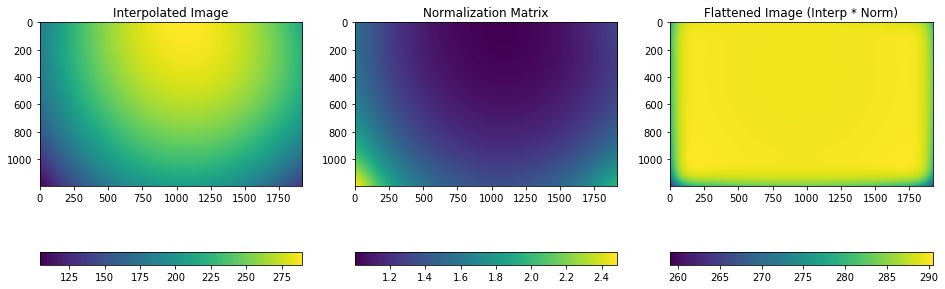

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (16,8))

plt0 = ax[0].imshow(interp1stCherry)
ax[0].set_title('Interpolated Image')
fig.colorbar(plt0, ax=ax[0], orientation = 'horizontal')

plt1 = ax[1].imshow(norm_mat_motor)
ax[1].set_title('Normalization Matrix')
fig.colorbar(plt1, ax=ax[1], orientation = 'horizontal')

plt2 = ax[2].imshow(interp1stCherry*norm_mat_motor)
ax[2].set_title('Flattened Image (Interp * Norm)')
fig.colorbar(plt2, ax=ax[2], orientation = 'horizontal');

Calibrate all of the images to flatten the image and convert to concentration units.

In [21]:
#Find the median background in the motor channel
im_motor_ref_calibrated = calibrate_motor(im_motor_ref, norm_mat_motor, offset_Cherry, \
                                      auto_fluo_Cherry, uM_per_intensity_motor)
motor_bg = np.median(im_motor_ref_calibrated)

#Calibrate all motor images to be in terms of concentration
im_motor_calibrated_all = []
for i in tqdm(range(n_asters)):
    im_motor_calibrated = calibrate_motor(im_motor[i], norm_mat_motor, offset_Cherry, \
                                    auto_fluo_Cherry, uM_per_intensity_motor)    
    im_motor_calibrated_all.append(im_motor_calibrated)
im_motor_calibrated_array = np.array(im_motor_calibrated_all)

  0%|          | 0/65 [00:00<?, ?it/s]

### ATP:

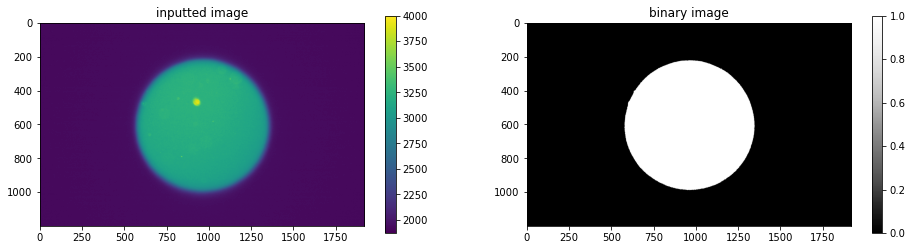

In [22]:
#Define data sets for im_motor ###USER INPUT###
im_iATP = im_arrayiATPPos2
im_iATP_ref = im_arrayiATPPos2[0]
im_binary = binary_im_generator(im_iATP_ref)

Orders of operations:
- interp
- norm
- cal

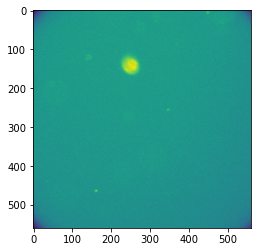

In [23]:
#circumscribed circle
x_l, x_h = 675, 1235
y_l, y_h = 325, 885
#inscrbed circle
# xrange = [560, 1350]
# yrange = [210, 1000]
test = im_iATP_ref[y_l:y_h, x_l:x_h]
plt.imshow(test)

In [24]:
#Create a mask of 1s and 0s that set all bright spots to 0.
masked1stiATP = 1 + np.zeros_like(brightdeliATP[y_l:y_h, x_l:x_h])
masked1stiATP[brightdeliATP[y_l:y_h, x_l:x_h] == 0] = 0

#Define data sets for im_motor ###USER INPUT###
im_iATP = im_arrayiATPPos2[:, y_l:y_h, x_l:x_h]
im_iATP_ref = im_arrayiATPPos2[0][y_l:y_h, x_l:x_h]

#Use the interpolation function to fill in the holes in the mask
interp1stiATP = interp_fn(im_iATP[0], masked1stiATP, 2)
#Keep only values greater than 0 in the interpolated image (negatives mess up the blur)
interp1stiATP[interp1stiATP <= 0] = 1

#Now there is a full picture use the normalization matrix to get a flat image
norm_mat_iATP = norm_mat_fn_iATP(interp1stiATP, offset_iATP)

#define the flattened image for the reference image:
flatteniATP_ref = interp1stiATP*norm_mat_iATP

In [25]:
np.max(interp1stiATP)

1350.159190694469

#### Zero level determination for ATP calibration (not part of regular protocol)

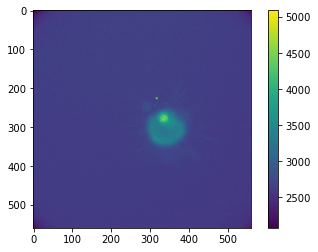

In [26]:
plt.imshow(im_iATP[-1])
plt.colorbar();

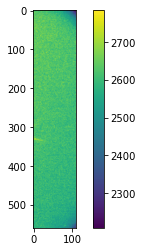

In [27]:
plt.imshow(im_iATP[-1][:, 450:])
plt.colorbar();

In [28]:
zeroATPfluor = []
for im in im_iATP:
    up_avg = np.average(im[0:100, :])
    down_avg = np.average(im[450:, :]) 
    left_avg = np.average(im[:, :100])
    right_avg = np.average(im[:, 450:])
    zeroATPfluor.append(np.average([up_avg, down_avg, left_avg, right_avg]))

The min value is 2595.5981233766233 at frame 44
The max value is 3155.652714285714 at frame 0


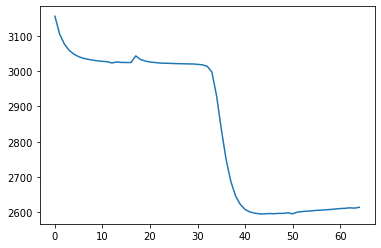

In [29]:
print('The min value is ' + str(np.min(zeroATPfluor)) + ' at frame ' 
      + str(np.where(zeroATPfluor==np.min(zeroATPfluor))[0][0]))
print('The max value is ' + str(np.max(zeroATPfluor)) + ' at frame ' 
      + str(np.where(zeroATPfluor==np.max(zeroATPfluor))[0][0]))
plt.plot(np.arange(0, len(im_iATP), 1), zeroATPfluor);
#plt.ylim(3025, 3200)

In [30]:
test_floor = np.percentile(im_iATP, 0.1)
print(test_floor)
len(im_iATP[30][np.where(im_iATP[30]<test_floor)])

2368.0


51

In [31]:
len(im_iATP[40][np.where(im_iATP[40]<np.min(zeroATPfluor))])

83803

#### Resume to interpolation

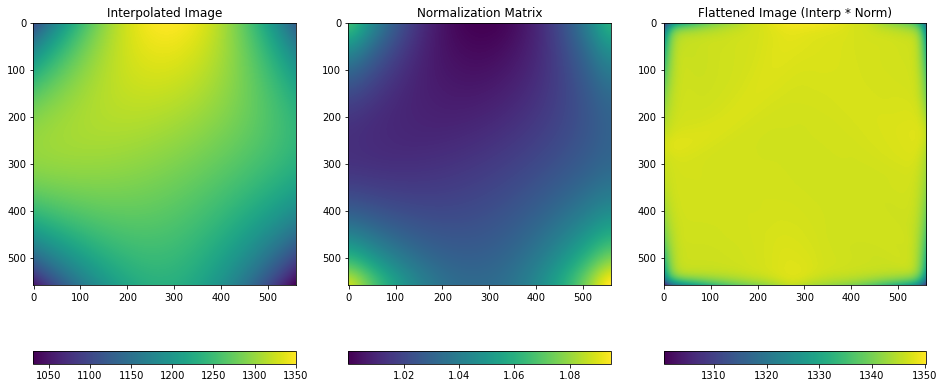

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (16,8))

plt0 = ax[0].imshow(interp1stiATP)
ax[0].set_title('Interpolated Image')
norm0=Normalize(np.min(interp1stiATP), np.max(interp1stiATP))
c0=cm.ScalarMappable(norm=norm0)
fig.colorbar(c0, ax=ax[0], orientation = 'horizontal')

plt1 = ax[1].imshow(norm_mat_iATP)
ax[1].set_title('Normalization Matrix')
norm1=Normalize(np.min(norm_mat_iATP), np.percentile(norm_mat_iATP, 80))
c1=cm.ScalarMappable(norm=norm1)
fig.colorbar(c1, ax=ax[1], orientation = 'horizontal')

plt2 = ax[2].imshow(flatteniATP_ref)
ax[2].set_title('Flattened Image (Interp * Norm)')
norm2=Normalize(np.min(flatteniATP_ref), np.max(flatteniATP_ref))
c2=cm.ScalarMappable(norm=norm2)
fig.colorbar(c2, ax=ax[2], orientation = 'horizontal');

In [35]:
im_iATP_calibrated_array = im_iATP

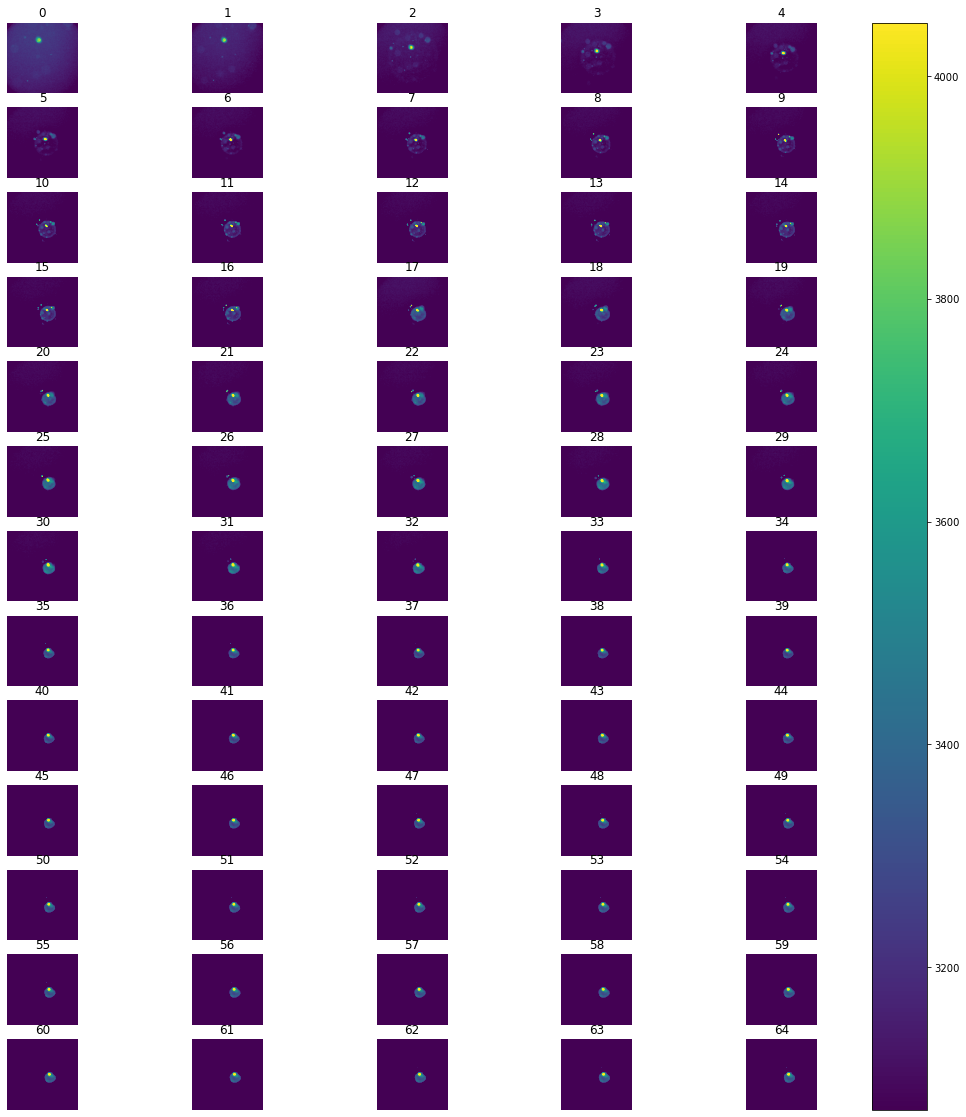

In [82]:
colorbar_min = np.percentile(im_iATP_calibrated_array, 80)
colorbar_max = np.percentile(im_iATP_calibrated_array, 99.9)

fig, axes = plt.subplots(nrows=int((len(im_iATP_calibrated_array)+0.5)/5), ncols=5, figsize = (20, 20))
cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((im_iATP_calibrated_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


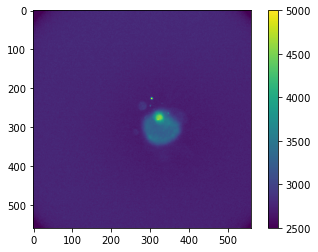

In [91]:
plt.imshow(im_iATP_calibrated_array[36], vmin=2500, vmax=5000)
plt.colorbar()

## Manual Center Identification

In doing the calibrations, we have already cropped the atp. Crop the motor and MT reference image so that all images are of the same size. Here I will just do single images a a time. Note im_MT_ref is frame 30

In [71]:
frame = 36
im_mot = im_motor_calibrated_array[frame][y_l:y_h, x_l:x_h]
im_atp = im_iATP_calibrated_array[frame]
im_MT = im_MT_ref[y_l:y_h, x_l:x_h]

Here do a tight crop to manually set and define the center of the aster:

Text(0.5, 1.0, 'iATP channel')

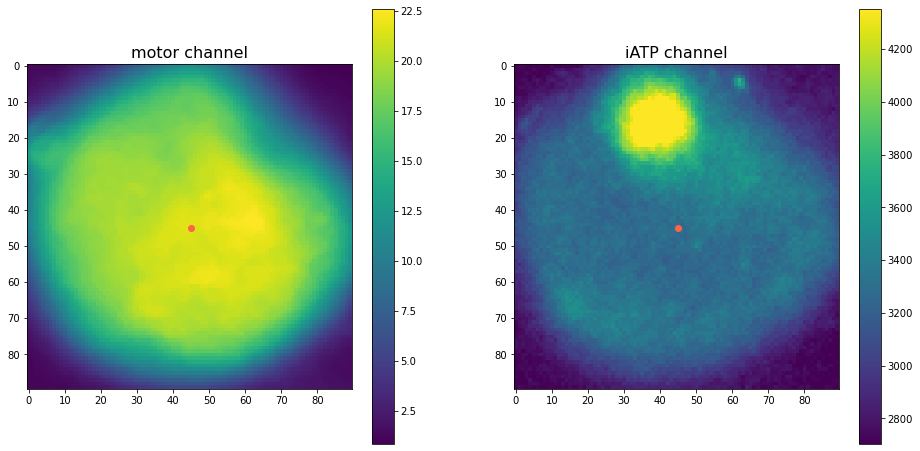

In [72]:
# np.s_ sets up an index tuple. Here define the window of interest and apply this region to im_mot and im_atp:
j_min, j_max, i_min, i_max = 260, 350, 285, 375

win = np.s_[j_min:j_max, i_min:i_max]
im_motwin = im_mot[win]
im_atpwin = im_atp[win]

#Set the aster center through visual inspection (this is relative to the set window)
i_cent_win, j_cent_win = int((j_max-j_min)/2), int((i_max - i_min)/2)
i_cent, j_cent = i_min + i_cent_win, j_min + j_cent_win

#plot to visually check center:
fig, ax = plt.subplots(1,2,figsize=(16,8))

im_plot = ax[0].imshow(im_motwin)
fig.colorbar(im_plot, ax=ax[0], orientation='vertical')
ax[0].scatter(i_cent_win, j_cent_win,color='tomato')
ax[0].set_title('motor channel', fontsize=16)

im_plot2 = ax[1].imshow(im_atpwin, vmin = np.percentile(im_atpwin, 1), vmax = np.percentile(im_atpwin, 98))
fig.colorbar(im_plot2, ax=ax[1], orientation='vertical')
ax[1].scatter(i_cent_win, j_cent_win,color='tomato')
ax[1].set_title('iATP channel', fontsize=16)

Text(0.5, 1.0, 'MT reference channel')

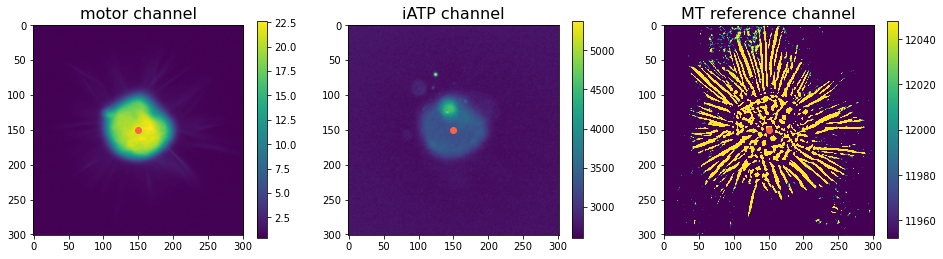

In [73]:
winsize = 150
w_centering = int(0.8*winsize)

new_win = np.s_[j_cent-winsize:j_cent+winsize+1, i_cent-winsize:i_cent+winsize+1]
im_mot_cent = im_mot[new_win]
im_atp_cent = im_atp[new_win]
im_MT_cent = im_MT[new_win]

#Plot the images with labeled centers
fig, ax = plt.subplots(1,3,figsize=(16,8))

im_plot = ax[0].imshow(im_mot_cent)
fig.colorbar(im_plot, ax=ax[0], orientation='vertical', shrink=0.5)
ax[0].scatter(winsize,winsize,color='tomato')
ax[0].set_title('motor channel', fontsize=16)

im_plot2 = ax[1].imshow(im_atp_cent)
fig.colorbar(im_plot2, ax=ax[1], orientation='vertical', shrink=0.5)
ax[1].scatter(winsize,winsize,color='tomato')
ax[1].set_title('iATP channel', fontsize=16)

im_plot3 = ax[2].imshow(im_MT_cent, vmin = np.percentile(im_MT_cent, 80), vmax = np.percentile(im_MT_cent, 85))
fig.colorbar(im_plot3, ax=ax[2], orientation='vertical', shrink=0.5)
ax[2].scatter(winsize,winsize,color='tomato')
ax[2].set_title('MT reference channel', fontsize=16)

## Traces

In [74]:
r_outer_px = 125
r_outer_um = r_outer_px*um_per_pixel

r_inner_px = 55
r_inner_um = r_inner_px*um_per_pixel

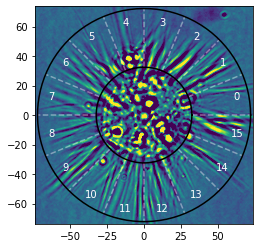

In [75]:
#######################################################################
# --------------- Show aster with boundaries & wedges --------------- #
#######################################################################

im = im_MT_cent
W,_ = im.shape
W_half=int(0.5*W)

plt.imshow(im[W_half-r_outer_px:W_half+r_outer_px,W_half-r_outer_px:W_half+r_outer_px], \
           origin='lower', \
           extent = (-r_outer_um, r_outer_um, -r_outer_um, r_outer_um),\
           vmin = np.percentile(im_MT_cent, 5), vmax = np.percentile(im_MT_cent, 99))

n_wedge = 16
angle_bins = np.radians(np.linspace(0,360,n_wedge+1))
angles = 0.5*(angle_bins[1:] + angle_bins[0:-1])

for i in range(len(angle_bins)-1):
    angle = angle_bins[i]
    xx = [r_inner_um*np.cos(angle), 0.98*r_outer_um*np.cos(angle)]
    yy = [r_inner_um*np.sin(angle), 0.98*r_outer_um*np.sin(angle)]
    plt.plot(xx, yy, '--', color='w', alpha=0.4)

    dangle = angle_bins[1]-angle_bins[0]
    x_text = 0.87*r_outer_um*np.cos(angle+0.5*dangle)
    y_text = 0.87*r_outer_um*np.sin(angle+0.5*dangle)
    plt.text(x_text, y_text, str(i), color='w', alpha=1,\
             horizontalalignment='center', verticalalignment='center')
    
thetas = np.linspace(0,2*np.pi,200)

x_circ_inner = r_inner_um*np.cos(thetas)
y_circ_inner = r_inner_um*np.sin(thetas)
plt.plot(x_circ_inner, y_circ_inner, color='black', alpha=1)

x_circ_outer = 0.98*r_outer_um*np.cos(thetas)
y_circ_outer = 0.98*r_outer_um*np.sin(thetas)
plt.plot(x_circ_outer, y_circ_outer, color='black', alpha=1)

# plt.gca().set_xticklabels(['']*10)
# plt.gca().set_yticklabels(['']*10)
# plt.show()

In [76]:
output_mot = profile_fn(im_mot_cent, r_min=r_inner_px, r_max=r_outer_px, avg_method='median', n_positions=int(winsize/3))
output_atp = profile_fn(im_atp_cent, r_min=r_inner_px, r_max=r_outer_px, avg_method='median', n_positions=int(winsize/3))
output_MT = profile_fn(im_MT_cent, r_min=r_inner_px, r_max=r_outer_px, avg_method='median', n_positions=int(winsize/3))

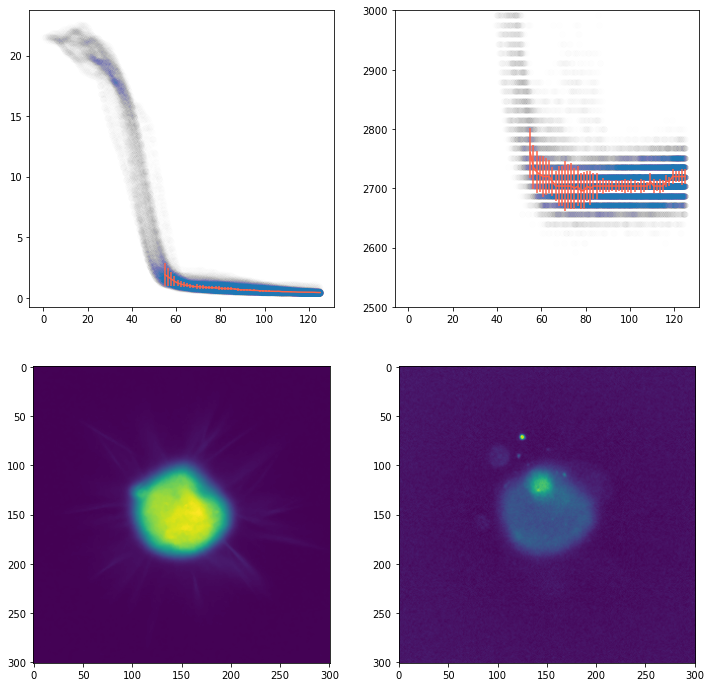

In [86]:
#plot the motor profile
fig, ax = plt.subplots(2,2,figsize=(12,12))

#alpha makes each point transparent darkness corresponds to number of points
ax[0,0].scatter(output_mot['r_ls'], output_mot['im_ls'], alpha = 0.005)
ax[0,1].scatter(output_atp['r_ls'], output_atp['im_ls'], alpha = 0.005)

#plot the averages
ax[0,0].errorbar(output_mot['r_unif_ls'],output_mot['avg_ls'], yerr = output_mot['std_ls'], color = 'tomato')
ax[0,1].errorbar(output_atp['r_unif_ls'],output_atp['avg_ls'], yerr = output_atp['std_ls'], color = 'tomato')

#set the axis scales
#ax[0,0].set_ylim(1500, 12000)
ax[0,1].set_ylim(2500, 3000)

#plot the images
ax[1,0].imshow(im_mot_cent)
ax[1,1].imshow(im_atp_cent)

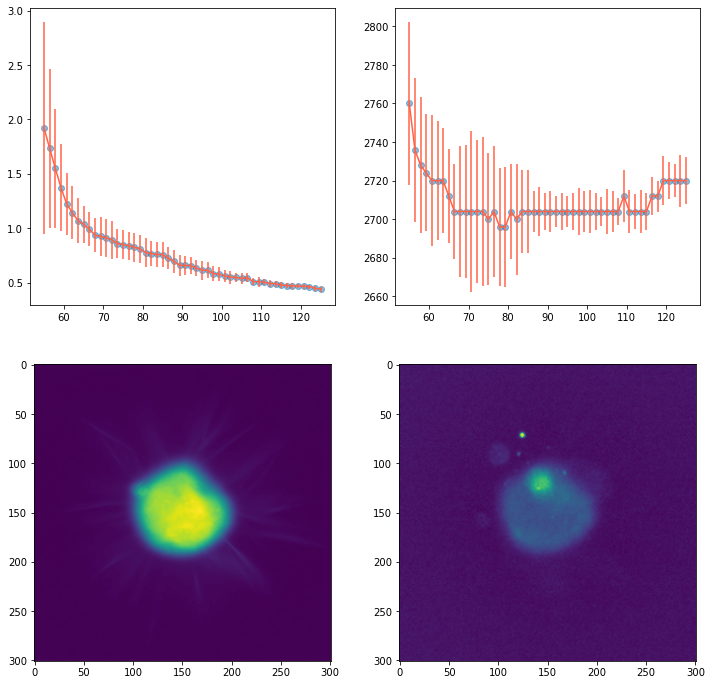

In [78]:
#plot the motor profile
fig, ax = plt.subplots(2,2,figsize=(12,12))

#alpha makes each point transparent darkness corresponds to number of points
ax[0,0].scatter(output_mot['r_unif_ls'], output_mot['avg_ls'], alpha = 0.5)
ax[0,1].scatter(output_atp['r_unif_ls'], output_atp['avg_ls'], alpha = 0.5)

#plot the averages
ax[0,0].errorbar(output_mot['r_unif_ls'],output_mot['avg_ls'], yerr = output_mot['std_ls'], color = 'tomato')
ax[0,1].errorbar(output_atp['r_unif_ls'],output_atp['avg_ls'], yerr = output_atp['std_ls'], color = 'tomato')

#set the axis scales
#ax[0,0].set_ylim(1500, 12000)
#ax[0,1].set_ylim(1100, 1250)

#plot the images
ax[1,0].imshow(im_mot_cent)
ax[1,1].imshow(im_atp_cent)

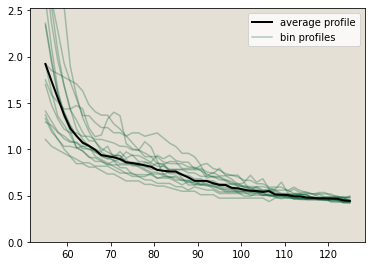

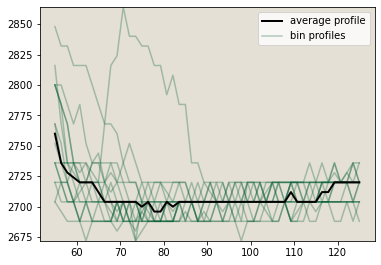

In [79]:
motor_profile_mat = output_mot['avg_bin_mat']
atp_profile_mat = output_atp['avg_bin_mat']

fig, ax = plt.subplots(figsize=(6, 4.3)) 
plt.plot(output_mot['r_unif_ls'], output_mot['avg_ls'], color='k', lw=2.0, zorder=100) 
for i in range(len(motor_profile_mat)):
    plt.plot(output_mot['r_unif_ls'], motor_profile_mat[i], color='#005C34', alpha=0.30)
plt.ylim([0, 0.5*motor_profile_mat.max()]) 
plt.gca().legend(('average profile','bin profiles')) 
ax.set_facecolor(color_background) 
# plt.gca().set_xticklabels(['']*10) 
# plt.gca().set_yticklabels(['']*10)

fig, ax = plt.subplots(figsize=(6, 4.3)) 
plt.plot(output_atp['r_unif_ls'], output_atp['avg_ls'], color='k', lw=2.0, zorder=100) 
for i in range(len(atp_profile_mat)):
    plt.plot(output_atp['r_unif_ls'], atp_profile_mat[i], color='#005C34', alpha=0.30)
plt.ylim([1*atp_profile_mat.min(), 1*atp_profile_mat.max()]) 
plt.gca().legend(('average profile','bin profiles')) 
ax.set_facecolor(color_background) 
# plt.gca().set_xticklabels(['']*10) 
# plt.gca().set_yticklabels(['']*10)



## Center Identification (currently flawed, dont run if doing manual)

trying for all the asters in the time series

In [45]:
im_mot = im_motor_calibrated_array[30][y_l:y_h, x_l:x_h]
im_atp = im_iATP_calibrated_array[30]
im_MT = im_MT_ref[y_l:y_h, x_l:x_h]

j_cent, i_cent = 330, 305
winsize = 280
new_win = np.s_[j_cent-winsize:j_cent+winsize+1, i_cent-winsize:i_cent+winsize+1]
im_motwin2 = im_mot[new_win]
im_atpwin2 = im_atp[new_win]
im_MTwin2 = im_MT[new_win]

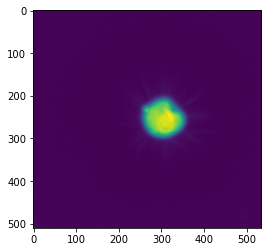

In [46]:
plt.imshow(im_motor_calibrated_array[30][y_l:y_h, x_l:x_h][new_win])

In [47]:
#Tighter crop window - note only on the motor channel because this is already applied to ATP channel
j_cent, i_cent = 330, 305
winsize = 280
new_win = np.s_[j_cent-winsize:j_cent+winsize+1, i_cent-winsize:i_cent+winsize+1]

aster_centers = []

# Lists to store cropped aster images centered
# at the identified aster centers
im_motor_calibrated_centered_all = []
im_atp_calibrated_centered_all = []

# Half-width of centered images
w=140
w_centering = int(0.8*w)

for j in tqdm(range(13)): ###range(n_asters)):
    i=j+42
    index = diameters_all.index(diameters_all[i])
    
    diameter = diameters_all[index]
    w_half = w_half_vals[index]
    r_thresh = r_thresh_vals[index]
    r_blur = r_blur_vals[index]
    
    if diameter < 100:
        least_squares = False
    else:
        least_squares = True
    
    # Calibrated images
    im_motor = im_motor_calibrated_array[i][y_l:y_h, x_l:x_h][new_win]
    im_atp = im_iATP_calibrated_array[i][new_win]
    
    # Motor image with the bright spots removed
    #im_motor_rm = remove_spots(np.copy(im_motor), motor_bg_ls[i])
    
    i_center, j_center = find_center(im_motor, int(w_half), r_thresh, \
                                     r_blur=r_blur, motor=motor, least_squares = least_squares)
    
    aster_centers.append([i_center, j_center])
    
    im_motor_centered = im_motor[i_center-w_centering:i_center+w_centering+1,\
                                 j_center-w_centering:j_center+w_centering+1]
    im_motor_calibrated_centered_all.append(im_motor_centered)
    
    im_atp_centered = im_atp[i_center-w_centering:i_center+w_centering+1,\
                           j_center-w_centering:j_center+w_centering+1]
    im_atp_calibrated_centered_all.append(im_atp_centered)
    
    if im_atp_centered.shape[0] != 2*w_centering+1 or im_atp_centered.shape[1] != 2*w_centering+1:
        print('Warning! Frame '+ str(i) + ', i_center: ' +str(i_center) + ', j_center: ' + str(j_center))

  0%|          | 0/13 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (177,177) (175,177) (177,177) 

In [ ]:
np.shape(im_motor_calibrated_array[40][y_l:y_h, x_l:x_h][new_win])

In [ ]:
colorbar_min = np.percentile(im_motor_calibrated_centered_all, 70)
colorbar_max = np.percentile(im_motor_calibrated_centered_all, 99)

fig, axes = plt.subplots(nrows=int((len(im_motor_calibrated_centered_all)+0.5)/5), ncols=5, figsize = (20, 20))
cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((im_motor_calibrated_centered_all[i]),cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

single aster

In [ ]:
diameter = diameters_all[30]
index = diameters_all.index(diameter) 
w_half = w_half_vals[index] 
r_thresh = r_thresh_vals[index] 
r_blur = r_blur_vals[index]

test_mot = im_motor_calibrated_array[30][y_l:y_h, x_l:x_h][new_win]
test_atp = im_iATP_calibrated_array[30][new_win]


w =100
w_centering = int(0.8*w)

if diameter <= 100:
    least_squares = False
else:
    least_squares = True
    
# Use calibrated images for center identification 
im_motor_copy = np.copy(test_mot) 
im_atp_copy = np.copy(test_atp)
im_MT_copy = np.copy(im_MTwin2)

i_center, j_center = find_center(im_motor_copy, int(w_half), r_thresh, r_blur=r_blur, \
                                 motor=motor, least_squares = least_squares)

im_motor_centered = im_motor_copy[i_center-w_centering:i_center+w_centering+1,\
                             j_center-w_centering:j_center+w_centering+1]

im_atp_centered = im_atp_copy[i_center-w_centering:i_center+w_centering+1,\
                       j_center-w_centering:j_center+w_centering+1]

im_MT_centered = im_MT_copy[i_center-w_centering:i_center+w_centering+1,\
                       j_center-w_centering:j_center+w_centering+1]

if im_MT_centered.shape[0] != 2*w_centering+1 or im_MT_centered.shape[1] != 2*w_centering+1:
    print('WARNING!')

In [ ]:
plt.imshow(im_motor_centered, 
           vmin = 12000, 
           vmax = 12500)
plt.colorbar()

In [ ]:
MT_ref_cent = aster_centers[30]
plt.imshow(im_MT[new_win][MT_ref_cent[0]-w_centering:MT_ref_cent[0]+w_centering+1,\
                 MT_ref_cent[1]-w_centering:MT_ref_cent[1]+w_centering+1], 
           vmin = 12000, 
           vmax = 12500)
plt.colorbar()

In [ ]:
print(MT_ref_cent)
print(np.shape(im_MT_ref))
print(np.shape(im_MT))
print(np.shape(im_MT[y_l:y_h, x_l:x_h]))
print(np.shape(im_motor))

In [ ]:
plt.imshow(im_motor_calibrated_array[30][y_l:y_h, x_l:x_h][new_win][MT_ref_cent[0]-w_centering:MT_ref_cent[0]+w_centering+1,\
                 MT_ref_cent[1]-w_centering:MT_ref_cent[1]+w_centering+1])
plt.imshow(im_MT[MT_ref_cent[0]-w_centering:MT_ref_cent[0]+w_centering+1,\
                 MT_ref_cent[1]-w_centering:MT_ref_cent[1]+w_centering+1])

In [ ]:
plt.imshow(im_motor_calibrated_centered_all[30], vmin = 0, vmax = 8)
plt.colorbar()

## Skipping over the calibrations etc, I am getting traces for the profiles:

Until there is a standardized center identification procedure, I will manually find centers for the traces, thus I will start with a smaller sample size of images. In this first cell, define the motor and atp frame of interest for single image analysis:

In [ ]:
output_mot = profile_fn_nowedge(im_mot_cent, r_min=0, dr=3, r_max=winsize, avg_method='median', n_positions=int(winsize/3))
output_atp = profile_fn_nowedge(im_atp_cent, r_min=0, dr=3, r_max=winsize, avg_method='median', n_positions=int(winsize/3))

In [ ]:
len(output_mot['r_unif_ls'])

In [ ]:
#plot the motor profile
fig, ax = plt.subplots(2,2,figsize=(12,12))

#alpha makes each point transparent darkness corresponds to number of points
ax[0,0].scatter(output_mot['r_ls'], output_mot['im_ls'], alpha = 0.005)
ax[0,1].scatter(output_atp['r_ls'], output_atp['im_ls'], alpha = 0.005)

#plot the averages
#ax[0,0].errorbar(output_mot['r_unif_ls'],output_mot['avg_ls'], yerr = output_mot['std_ls'], color = 'tomato')
ax[0,1].errorbar(output_atp['r_unif_ls'],output_atp['avg_ls'], yerr = output_atp['std_ls'], color = 'tomato')

#set the axis scales
#ax[0,0].set_ylim(1500, 12000)
ax[0,1].set_ylim(1100, 1700)

#plot the images
ax[1,0].imshow(im_mot_cent)
ax[1,1].imshow(im_atp_cent)

In [ ]:
#Get traces:
output_atp = []
output_mot = []
for i in tqdm(range(n_asters)):
    output_atp.append(profile_fn_nowedge(im_iATP_calibrated_array[i], r_min=0, dr=3, 
                                     r_max=winsize, avg_method='median', 
                                     n_positions=int(winsize/3)))    
    output_mot.append(profile_fn_nowedge(im_motor_calibrated_array[i][y_l:y_h, x_l:x_h], 
                                      r_min=0, dr=3, r_max=winsize, avg_method='median', 
                                      n_positions=int(winsize/3)))

In [ ]:
output_atp[10]['r_ls']

In [ ]:
index=30

#plot the motor profile
fig, ax = plt.subplots(2,2,figsize=(12,12))

#alpha makes each point transparent darkness corresponds to number of points
ax[0,0].scatter(output_mot[index]['r_ls'], output_mot[index]['im_ls'], alpha = 0.005)
ax[0,1].scatter(output_atp[index]['r_ls'], output_atp[index]['im_ls'], alpha = 0.005)

#plot the averages
#ax[0,0].errorbar(output_mot['r_unif_ls'],output_mot['avg_ls'], yerr = output_mot['std_ls'], color = 'tomato')
#ax[0,1].errorbar(output_atp['r_unif_ls'],output_atp['avg_ls'], yerr = output_atp['std_ls'], color = 'tomato')

#set the axis scales
#ax[0,0].set_ylim(1500, 12000)
ax[0,1].set_ylim(1100, 1500)

#plot the images
ax[1,0].imshow(im_motor_calibrated_array[index][y_l:y_h, x_l:x_h])
ax[1,1].imshow(im_iATP_calibrated_array[index])

In [ ]:
plt.scatter(output_atp[index]['r_ls'], output_atp[index]['im_ls'], alpha = 0.005)
plt.ylim(1100, 1700)
#plt.imshow(im_iATP_calibrated_array[index])

## Inner and Outer Boundary determination

In [ ]:
np.percentile(im_MT_cent, 98)

In [ ]:
tubulin_bg = 14000 #intensity value based on image

# ------------------ Outer boundary ------------------ #
im_motor_prof = np.copy(im_mot_cent)
im_MT_prof = np.copy(im_MT_cent)

profile_output = profile_fn(im_MT_prof, n_positions=100, avg_method = avg_method)
r_unif_ls = profile_output["r_unif_ls"]
avg_MT_ls = profile_output["avg_ls"]
tubulin_thresh = multi_bg*tubulin_bg
ind_thresh = np.where(avg_MT_ls < tubulin_thresh)[0][0]
r_outer_px = int(r_unif_ls[ind_thresh])
r_outer_um = um_per_pixel*int(r_unif_ls[ind_thresh])

print(avg_MT_ls)


In [ ]:
np.shape(im_MT_cent)

In [ ]:
print(np.shape(r_unif_ls))
print((np.shape(avg_MT_ls)))
print(np.shape(profile_output['r_ls']))
print(np.shape(radii_um))

In [ ]:
# ------------------ Final profile extraction ------------------ #
r_outer = r_outer_px
    
im_MT_crop = im_MT_prof[w_centering-r_outer:w_centering+r_outer, w_centering-r_outer:w_centering+r_outer]
im_motor_crop = im_motor_prof[w_centering-r_outer:w_centering+r_outer, w_centering-r_outer:w_centering+r_outer]

# MT profile data
profile_output = profile_fn(im_MT_crop, n_positions=100, avg_method = avg_method)
r_unif_ls = profile_output["r_unif_ls"]
avg_MT_ls = profile_output["avg_ls"]
MT_profile_mat = profile_output["avg_bin_mat"]
avg_MT_ls = avg_MT_ls[r_unif_ls < r_outer]

# Motor profile data
profile_output = profile_fn(im_motor_crop, n_positions=100, avg_method = avg_method)
print('here ' + str(np.shape(profile_output['avg_ls'])))
r_unif_ls = profile_output["r_unif_ls"]
avg_motor_ls = profile_output["avg_ls"]
print('then ' + str(np.shape(avg_motor_ls)))
motor_profile_mat = profile_output["avg_bin_mat"]
avg_motor_ls = avg_motor_ls[r_unif_ls < r_outer]

MT_profile = avg_MT_ls
motor_profile = avg_motor_ls
print('and then ' + str(np.shape(motor_profile)))

radii_px = r_unif_ls[r_unif_ls < r_outer]
radii_um = radii_px*um_per_pixel
print(np.shape(radii_um))
print(np.shape(motor_profile))


fig, ax = plt.subplots(figsize=(6, 4.3))
plt.plot(radii_um, motor_profile, color='k', lw=2.0, zorder=100)
for i in range(len(motor_profile_mat)):
    plt.plot(radii_um, motor_profile_mat[i], color='#005C34', alpha=0.30)
plt.ylim([0, 1.1*motor_profile_mat.max()])
plt.gca().legend(('average profile','bin profiles'))
ax.set_facecolor(color_background)
# plt.gca().set_xticklabels(['']*10)
# plt.gca().set_yticklabels(['']*10)
#plt.savefig('fig_outputs/data_processing/demo_motor_profile.pdf')


fig, ax = plt.subplots(figsize=(6, 4.3))
plt.plot(radii_um, MT_profile, color='k', lw=2.0, zorder=100)
for i in range(len(MT_profile_mat)):
    plt.plot(radii_um, MT_profile_mat[i], color='#005C34', alpha=0.30)
plt.ylim([0, 1.1*MT_profile_mat.max()])
plt.gca().legend(('average profile','bin profiles'))
ax.set_facecolor(color_background)
# plt.gca().set_xticklabels(['']*10)
# plt.gca().set_yticklabels(['']*10)
#plt.savefig('fig_outputs/data_processing/demo_MT_profile.pdf')

In [ ]:
# Smoothed profile for a more accurate identification 
# of the location of the highest slope 
motor_profile_sg = savgol_filter(motor_profile, 15, 2)

diff = motor_profile_sg[:-1] - motor_profile_sg[1:] 
ind_inner = np.where(diff == diff.max())[0][0]

x0 = radii_px[ind_inner] 
y0 = motor_profile_sg[ind_inner]

r_inner_px = x0 + 0.15*r_outer_px 
r_inner_um = um_per_pixel * r_inner_px


## Attempt at radial traces:

use the reference brightfield image to find the aster radius

In [ ]:
ff_cent_x = i_cent_win + i_min + x_l
ff_cent_y = j_cent_win + j_min + y_l

In [ ]:
plt.imshow(im_MT_ref, vmin = 11900, vmax=12500)
plt.colorbar()

In [ ]:
out_radius = 130
plt.imshow((im_MT_ref[ff_cent_y - out_radius:ff_cent_y + out_radius, ff_cent_x - out_radius:ff_cent_x + out_radius]), 
           vmin = 11900, 
           vmax = 12500)
plt.colorbar()

In [ ]:
inn_radius = 45
plt.imshow((im_MT_ref[ff_cent_y - inn_radius:ff_cent_y + inn_radius, ff_cent_x - inn_radius:ff_cent_x + inn_radius]))

In [ ]:
plt.imshow(im_atpwin2)

In [ ]:
plot_im_mot = im_mot[ff_cent_y - out_radius:ff_cent_y + out_radius, ff_cent_x - out_radius:ff_cent_x + out_radius]
plot_im_atp = im_atp[ff_cent_y - out_radius:ff_cent_y + out_radius, ff_cent_x - out_radius:ff_cent_x + out_radius]

output_mot = profile_fn(plot_im_mot, 
                        r_min=inn_radius, 
                        dr=3, 
                        r_max=out_radius, 
                        avg_method='median', 
                        n_positions=int(out_radius - inn_radius))
output_atp = profile_fn(plot_im_atp, 
                        r_min=inn_radius, 
                        dr=3, 
                        r_max=out_radius, 
                        avg_method='median', 
                        n_positions=int(out_radius - inn_radius))

In [ ]:
output_mot = profile_fn(im_motwin2, r_min=2, dr=3, r_max=winsize-4, avg_method='median', n_positions=int(winsize/3))
output_atp = profile_fn(im_atpwin2, r_min=2, dr=3, r_max=winsize-4, avg_method='median', n_positions=int(winsize/3))

In [ ]:
print(output_mot['r_unif_ls'])
print(' ')
print(output_mot['avg_ls'])
print(' ')
print(output_atp['r_unif_ls'])
print(' ')
print(output_atp['avg_ls'])

In [ ]:
#plot the motor profile
fig, ax = plt.subplots(2,2,figsize=(12,12))

#alpha makes each point transparent darkness corresponds to number of points
ax[0,0].scatter(output_mot['r_unif_ls'], output_mot['avg_ls'], alpha = 0.5)
ax[0,1].scatter(output_atp['r_unif_ls'], output_atp['avg_ls'], alpha = 0.5)

#plot the averages
ax[0,0].errorbar(output_mot['r_unif_ls'],output_mot['avg_ls'], yerr = output_mot['std_ls'], color = 'tomato')
ax[0,1].errorbar(output_atp['r_unif_ls'],output_atp['avg_ls'], yerr = output_atp['std_ls'], color = 'tomato')

#set the axis scales
#ax[0,0].set_ylim(1500, 12000)
ax[0,1].set_ylim(1100, 1250)

#plot the images
ax[1,0].imshow(im_motwin2)
ax[1,1].imshow(im_atpwin2)#plot the motor profile

In [ ]:
motor_profile_mat = output_mot['avg_bin_mat']
atp_profile_mat = output_atp['avg_bin_mat']

fig, ax = plt.subplots(figsize=(6, 4.3)) 
plt.plot(output_mot['r_unif_ls'], output_mot['avg_ls'], color='k', lw=2.0, zorder=100) 
for i in range(len(motor_profile_mat)):
    plt.plot(output_mot['r_unif_ls'], motor_profile_mat[i], color='#005C34', alpha=0.30)
plt.ylim([0, 1.1*motor_profile_mat.max()]) 
plt.gca().legend(('average profile','bin profiles')) 
ax.set_facecolor(color_background) 
# plt.gca().set_xticklabels(['']*10) 
# plt.gca().set_yticklabels(['']*10)

fig, ax = plt.subplots(figsize=(6, 4.3)) 
plt.plot(output_atp['r_unif_ls'], output_atp['avg_ls'], color='k', lw=2.0, zorder=100) 
for i in range(len(atp_profile_mat)):
    plt.plot(output_atp['r_unif_ls'], atp_profile_mat[i], color='#005C34', alpha=0.30)
plt.ylim([0.9*atp_profile_mat.min(), 1.1*atp_profile_mat.max()]) 
plt.gca().legend(('average profile','bin profiles')) 
ax.set_facecolor(color_background) 
# plt.gca().set_xticklabels(['']*10) 
# plt.gca().set_yticklabels(['']*10)

